## Part A Functions to Run Before training/Results

In [1]:
!pip install --upgrade --no-cache-dir gdown
!pip install pytorch_lightning &> /dev/null
!gdown 1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
!gdown 1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
!gdown 1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
!gdown 1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
!gdown 1h6VQWmbq41cJ9O1WdRalc8iOsox2HCeO # pretrained backbone

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1YuFkOkeZ_3iaf71W1QfaZqqO9nZq_QUy
To: /content/hw3_mycocodata_mask_comp_zlib.h5
100% 4.30M/4.30M [00:00<00:00, 68.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PDctbNuLSpxVU6MA-Qy6Unf_Q-bQf0jd
To: /content/hw3_mycocodata_labels_comp_zlib.npy
100% 269k/269k [00:00<00:00, 32.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_fR9WLy10WRzlZQBaMv8BFkT4f_4xr99
To: /content/hw3_mycocodata_img_comp_zlib.h5
100% 801M/801M [00:11<00:00, 72.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oSiBPjyxMOaC496rLVQA-xG-fgK1ulcA
To: /content/hw3_mycocodata_bboxes_comp_zlib.npy
100% 327k/327k [00:00<00:00, 123MB/s]
Downloading...
From: https://drive.google.com/uc?id=1h6VQWmbq41

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
from sklearn import metrics
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.axes3d import Axes
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import pytorch_lightning.loggers as pl_loggers
import pytorch_lightning.callbacks as pl_callbacks
from inspect import modulesbyfile
from torchvision.models.detection.image_list import ImageList
from BoxHead import *
from utils import *
import h5py
import albumentations as A
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
torch.set_printoptions(linewidth=100)

np.set_printoptions(linewidth=100)
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
# seed = 17
# torch.manual_seed(seed);

## Part B Training

In [2]:
# Put the path were you save the given pretrained model
device = 'cuda'

labels_og, bbox_og, imgs, masks_og= load_datset(viz=False)
dataset = BuildDataset(imgs, labels_og, bbox_og, masks_og)

# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset

# torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

batch_size = 2
print("batch size:", batch_size)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dataset.collate_fn)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dataset.collate_fn)
batch_tr = len(train_loader)
batch_val = len(test_loader)

batch size: 2


In [7]:
model= BoxHead(batch_tr,batch_val).to(device)

checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath='/content/drive/My Drive/680/hw4B/model_seedless/', every_n_epochs=1, filename='{epoch}_Model')
tb_logger = pl_loggers.TensorBoardLogger('')
# Train
trainer = pl.Trainer(logger=tb_logger, max_epochs=20, callbacks=[checkpoint_callback], accelerator='cuda')
# trainer = pl.Trainer(logger=tb_logger, max_epochs=30, callbacks=[checkpoint_callback], accelerator='cuda', resume_from_checkpoint='/content/drive/My Drive/680/hw4B/model_hopey/epoch=17_Model.ckpt')
# 
trainer.fit(model, train_loader, test_loader)

INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file drive/My Drive/680/Final Project/model_change/epoch=21_Model.ckpt`
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name               | Type             | Params
--------------------------------------------------------
0 | backbone           | BackboneWithFPN  | 26.8 M
1 | rpn                | RPNHead          | 27.4 M
2 | celoss       

Sanity Checking: 0it [00:00, ?it/s]

## Part C Results

### 1) GT Boxes

For the proposals We have a list containing 1 tensors
Each one with shape torch.Size([1000, 4])

For the features we have a list of features for each FPN level with shapes
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])


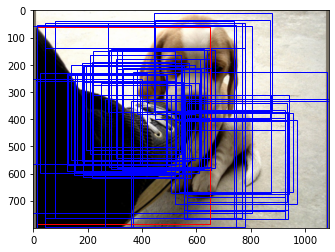

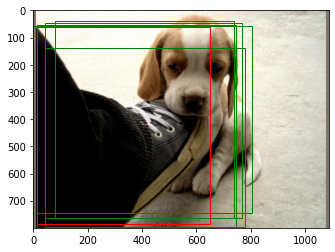

In [ ]:
plot_gt_boxes(model.backbone.to(device), model.rpn.to(device), test_loader, model, useours=True)

### 2) Plot Graphs

In [14]:
def plot_graphs():
  
 # Training
  total_loss =  [36.64426050113358, 7.657117395910598, 7.289528146954893, 6.045814434990628, 5.142247019833281, 4.96087583057753, 4.674567639372731, 3.7624148926662127, 3.3183553314390983, 3.1608777646800035, 3.093974194453873, 2.898547127501655, 2.824868832380717, 2.7383162552163802, 2.7062021007064643, 2.7231385537231243, 2.693297665765267, 2.6897608355711435, 2.661625452851521, 2.645922091626029]
  closs =  [0.7637736830888814, 0.48907286560034935, 0.427359331882637, 0.3815804583141367, 0.3350123100778984, 0.32105484738490964, 0.3075550721944061, 0.2778567685994483, 0.25865537143589656, 0.25873116143616554, 0.24395045685006006, 0.24254682400612204, 0.23659478164924921, 0.2288414298108857, 0.2307747556820853, 0.23059711817879486, 0.223423816377425, 0.23603982533832998, 0.23395538162297874, 0.2216681636343817]
  rloss = [35.880486532022026, 7.168044527978387, 6.862168828949674, 5.664233952078201, 4.80723470722446, 4.639820978841708, 4.367012573562506, 3.4845581250336335, 3.059699952829885, 2.902146602859934, 2.8500237312480694, 2.6560003022656185, 2.5882740516698997, 2.5094748230380866, 2.475427349787632, 2.4925414371581476, 2.469873843529752, 2.4537210141429466, 2.427670075238206, 2.4242539369422973]
  # Validation
  total_val_loss = [8.397365660378426, 6.92043462305358, 6.838617996736006, 6.049192638108225, 6.174843506379561, 5.689962845860106, 5.716002930294383, 4.834863438750759, 4.5137005213535195, 4.353062221498201, 4.609620860128691, 4.526251648411606, 4.2705046949964585, 4.2931043740474815, 4.362383658235723, 4.295454381090222, 4.262746066758127, 4.238781293233235, 4.283158930865201, 4.0775687802921645]  
  closs_val = [0.593655601143837, 0.4349431795152751, 0.4067425633018667, 0.38566069395253155, 0.35268145370664017, 0.36615817655216565, 0.33575493616588187, 0.30498982006401726, 0.3184984299269589, 0.2653724855997346, 0.2863843260953824, 0.29294460560336255, 0.29418802893523016, 0.2666037254825686, 0.26801918751814147, 0.280724553222006, 0.3042098269656752, 0.2563815667773738, 0.28207690827548504, 0.27582357747649605]
  rloss_val = [7.803710023562114, 6.485491449182684, 6.431875409501972, 5.663531968087861, 5.822162042964589, 5.323804656664531, 5.380247997515129, 4.5298736041242424, 4.195202085104856, 4.087689719416878, 4.323236541314558, 4.233307056354754, 3.9763166615457246, 4.026500631462444, 4.094364460670587, 4.014729841188951, 3.9585362419937598, 3.9823997418085733, 4.001082026597225, 3.8017452070207307]
  
  # Training Loss vs Epochs
  plt.plot(range(len(total_loss)), total_loss, label="Train Loss")
  plt.plot(range(len(total_val_loss)), total_val_loss, label="Validation Loss")
  plt.title("Epoch Vs Total Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(closs)), closs, label="Train Category Loss")
  plt.plot(range(len(closs_val)), closs_val, label="Validation Category Loss")
  plt.title("Epoch Vs Category Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()

  plt.plot(range(len(rloss)), rloss, label="Train Regressor Loss")
  plt.plot(range(len(rloss_val)), rloss_val, label="Validation Regressor Loss")
  plt.title("Epoch Vs Regressor Loss")
  plt.legend()
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.show()


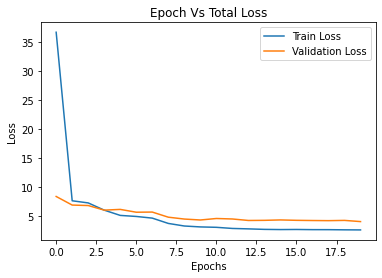

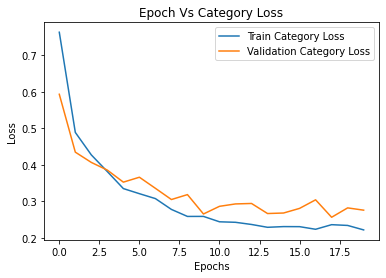

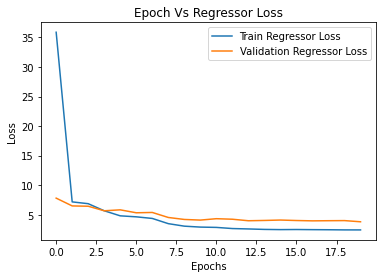

In [15]:
plot_graphs()

### 3) Top 20 Predictions

In [ ]:
device = 'cuda'
model = BoxHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/hw4B/model_seedless/epoch=18_Model.ckpt')
model =  model.to(device)
backbone, rpn = pretrained_models_680(pretrained_path, useours=False)
# backbone, rpn = pretrained_models_680(checkpoint_ours, useours=True)
useours=False

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=dataset.collate_fn)

for iter, batch in enumerate(test_loader, 0):
  images, labels, boxes, masks, indexes = batch
  break
images = images.to(device)

backout = backbone(images.float())
if useours:
  logits, reg_bbox = rpn.forward(images.float())
  _ , proposals= rpn.postprocessImg(logits,reg_bbox, 0.5, 2000, 1000)
  proposals = [proposals]

else:
  im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
  rpnout = rpn(im_lis, backout)
  keep_topK = 200
  proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]  

fpn_feat_list= list(backout.values())

feature_vectors = model.MultiScaleRoiAlign(fpn_feat_list,proposals)
class_logits, box_pred= model.forward(feature_vectors.to(device), eval=True)
fin_conf, fin_postbox, fin_lab = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=2000, keep_num_postNMS=200)

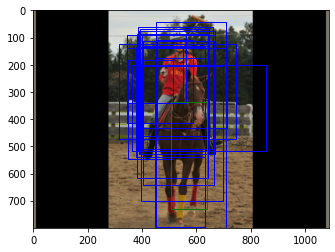

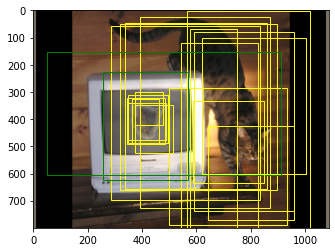

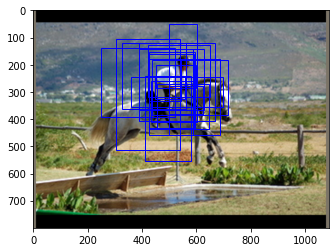

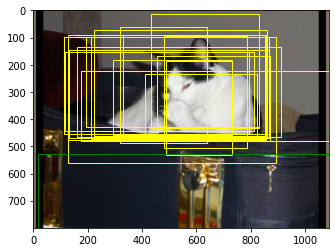

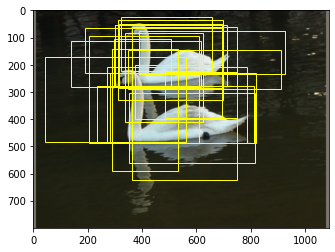

In [ ]:
plot_topK(5, backbone.to(device), rpn.to(device))

### 4) mAP Score and AP

In [ ]:
total_matches, total_scores, total_trues = mean_average_precision(model, rpn, backbone)
AP=0
ap_list = []
cnt =0
for c in range(3):
  if (len(total_matches[c])>0):
    area, precision_mat, recall_mat = average_precision(total_matches[c],total_scores[c],total_trues[c])
    AP  += area
    ap_list.append(area)
    plt.figure()
    plt.plot(recall_mat, precision_mat)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Class "+str(c))
    plt.show()
    print(area)
    cnt+=1;
  if cnt>0:
    map=AP/cnt
print("Mean Average Precision is : ", map)
print("Average Precision is : ", ap_list)

### 5) Before and After Post Processing

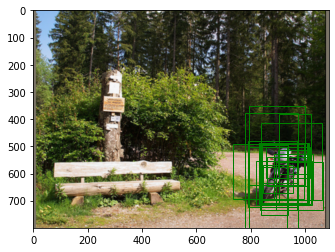

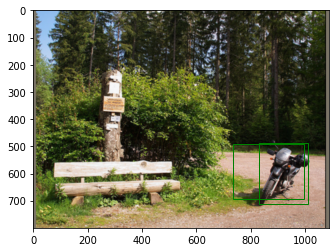

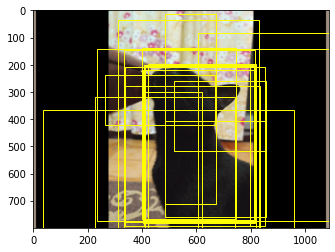

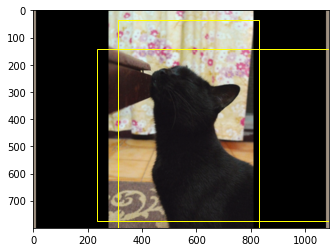

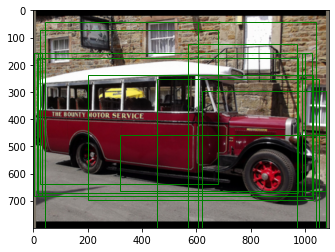

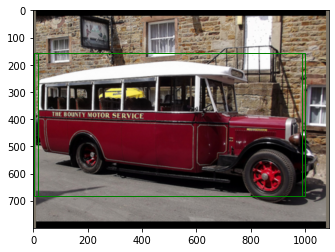

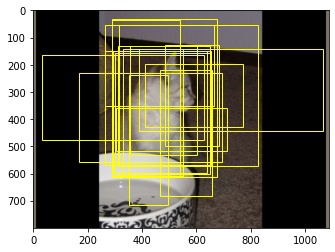

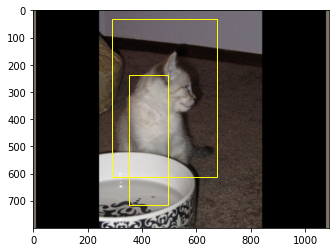

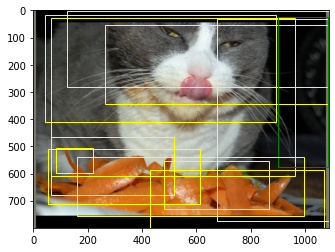

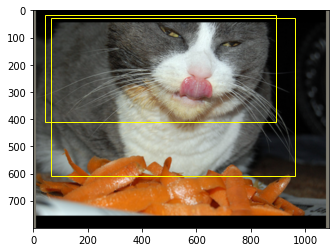

In [ ]:
plot_topKvsnms(ktimes=5)

### Evaluation Test

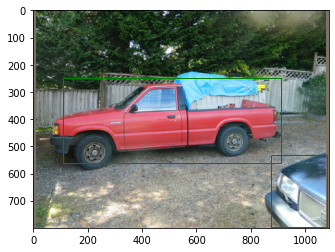

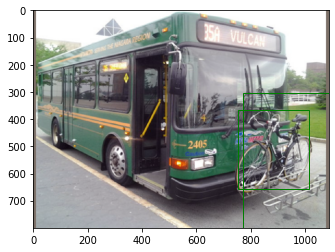

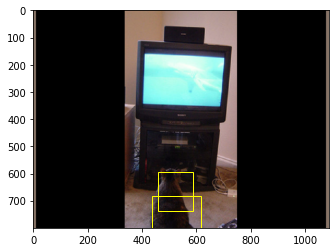

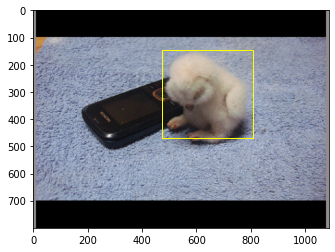

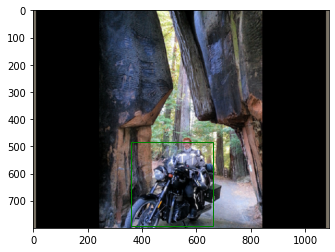

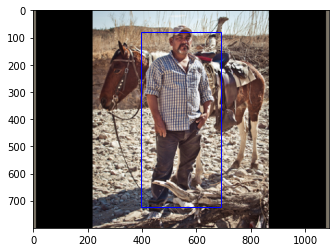

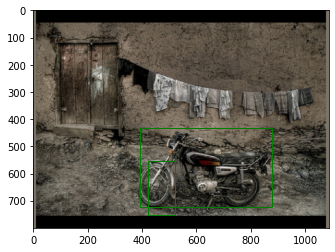

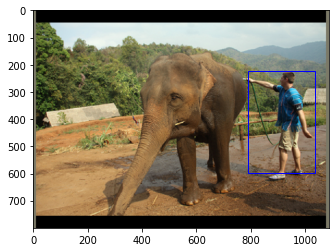

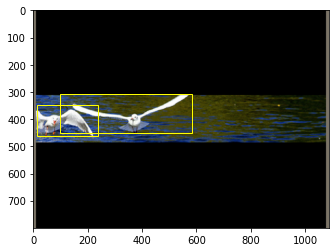

In [ ]:
# Put the path were the given hold_out_images.npz file is save and load the images
hold_images_path='/content/drive/My Drive/680/hw4/HW4_PartB_Code_Template/hold_out_images.npz'
test_images=np.load(hold_images_path,allow_pickle=True)['input_images']
backbone, rpn = pretrained_models_680(pretrained_path, useours=False)

# Load your model here. If you use different parameters for the initialization you can change the following code
# accordingly
device = 'cuda'
model = BoxHead.load_from_checkpoint(checkpoint_path='/content/drive/My Drive/680/hw4B/model_attached/epoch=22_Model.ckpt')
model =  model.to(device)
keep_topK=200
backbone = backbone.to(device)
rpn = rpn.to(device)
cpu_boxes = []
cpu_scores = []
cpu_labels = []

for i, numpy_image in enumerate(test_images, 0):
    images = torch.from_numpy(numpy_image).to(device)
    with torch.no_grad():
        # Take the features from the backbone
        backout = backbone(images)

        im_lis = ImageList(images, [(800, 1088)]*images.shape[0])
        rpnout = rpn(im_lis, backout)

        #The final output is
        # A list of proposal tensors: list:len(bz){(keep_topK,4)}
        proposals=[proposal[0:keep_topK,:] for proposal in rpnout[0]]
        # A list of features produces by the backbone's FPN levels: list:len(FPN){(bz,256,H_feat,W_feat)}
        fpn_feat_list= list(backout.values())

        feature_vectors=model.MultiScaleRoiAlign(fpn_feat_list,proposals)

        class_logits,box_pred=model.forward(feature_vectors.detach(), eval=True)

        # Do whaterver post processing you find performs best
        scores, boxes, labels = model.postprocess_detections(class_logits, box_pred, proposals, conf_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=3)        

        if (i>30 and i<40) and boxes is not 0:
          img_squeeze=images[0,:,:,:].to('cpu').numpy()
          x_min = img_squeeze.min(axis=(1, 2), keepdims=True)
          x_max = img_squeeze.max(axis=(1, 2), keepdims=True)
          img_squeeze = (img_squeeze - x_min)/(x_max-x_min)
          fig,ax=plt.subplots(1,1)
          ax.imshow(np.transpose(img_squeeze, axes=(1,2,0)))
          c=['none', 'green', 'blue','yellow']
          for no in range(len(boxes)):
              box=boxes[no].detach().cpu().numpy()
              lab= labels[no].item()
              rect=Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],fill=False,color=c[lab])
              ax.add_patch(rect)
          plt.show()   

        if boxes is 0:
            cpu_boxes.append(None)
            cpu_scores.append(None)
            cpu_labels.append(None)
        else:
            cpu_boxes.append(boxes.to('cpu').detach().numpy())
            cpu_scores.append(scores[:,0].to('cpu').detach().numpy())
            cpu_labels.append(labels[:,0,0].to('cpu').detach().numpy())

np.savez('predictions.npz', predictions={'boxes': cpu_boxes, 'scores': cpu_scores,'labels': cpu_labels})